# 2. Basic prediction

In [64]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [65]:
data_url = 'data.pkl'
df = pd.read_pickle(data_url)
df.head()

,Date,usd_aud,Fuel_price,Oil_price
33,2019-06-03,0.6977,127.3,53.25
34,2019-06-04,0.6991,127.3,53.50
35,2019-06-05,0.6970,127.3,51.57
36,2019-06-06,0.6977,127.3,52.59
37,2019-06-07,0.6999,126.3,53.95


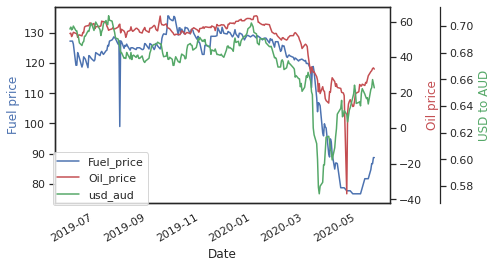

In [66]:
# Let's plot the raw data
ax = df.plot(x="Date", y="Fuel_price", legend=False, color="b")
ax2 = ax.twinx()
df.plot(x="Date", y="Oil_price", ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
df.plot(x="Date", y="usd_aud", ax=ax3, legend=False, color="g")

ax.set_xlabel("Date")
ax.set_ylabel("Fuel price")
ax2.set_ylabel("Oil price")
ax3.set_ylabel("USD to AUD")

ax.yaxis.label.set_color(color="b")
ax2.yaxis.label.set_color(color="r")
ax3.yaxis.label.set_color(color="g")

ax.figure.legend(bbox_to_anchor=(0.11, 0.2), loc='lower left')
plt.show()

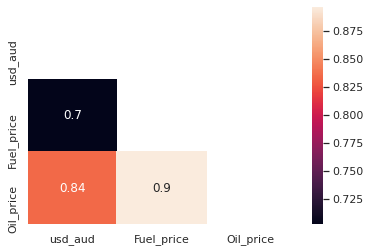

In [67]:
corr = df.corr()

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

In [68]:
# Checking if the data is stationary

for column in df.columns[1:]:
    print('Adfuller for', column)
    X = df[column].values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

Adfuller for usd_aud
ADF Statistic: -1.420960
p-value: 0.572187
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573


Adfuller for Fuel_price
ADF Statistic: -0.377083
p-value: 0.913855
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


Adfuller for Oil_price
ADF Statistic: -0.920626
p-value: 0.781104
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573




So, the time series data is not stationary so not ready to be machine learned.

## 2.1 Using only oil price and fuel price predicting based off means

In [69]:
# Create a 10 day rolling average of oil prices
df['Oil_price_rolling'] = df['Oil_price'].rolling(5, win_type='triang').sum()/3
df.head(15)

,Date,usd_aud,Fuel_price,Oil_price,Oil_price_rolling
33,2019-06-03,0.6977,127.3,53.25,NaN
34,2019-06-04,0.6991,127.3,53.50,NaN
35,2019-06-05,0.6970,127.3,51.57,NaN
36,2019-06-06,0.6977,127.3,52.59,NaN
37,2019-06-07,0.6999,126.3,53.95,52.676667
40,2019-06-10,0.6964,119.3,53.33,52.848889
41,2019-06-11,0.6963,119.3,53.30,53.173333
42,2019-06-12,0.6929,123.5,51.13,53.134444
43,2019-06-13,0.6914,122.7,52.38,52.794444
44,2019-06-14,0.6873,121.7,52.47,52.283333


Ratio  is 2.447921484949144


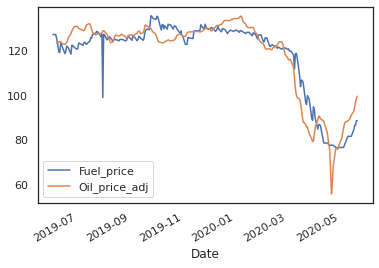

In [70]:
# Calculate ratio to scale oil price to get same as fuel price
ratio_oil_fuel = df['Fuel_price'].mean() / df['Oil_price_rolling'].mean()
print('Ratio  is', ratio_oil_fuel)
# Apply ratio
df['Oil_price_adj'] = df['Oil_price_rolling'] * ratio_oil_fuel
# Squeeze plot in y direction
mean = df['Oil_price_adj'].mean()
df['Oil_price_adj'] = (df['Oil_price_adj'] - mean) * 0.5 + mean
# Plot with ratio
ax = df.plot(x="Date", y="Fuel_price")
ax1 = df.plot(x="Date", y="Oil_price_adj", ax=ax)
plt.show()

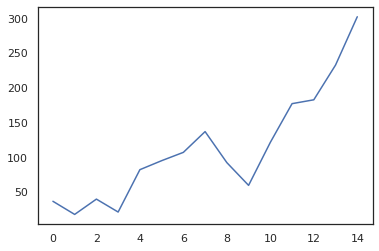

In [71]:
# Now calculate the days shift to get the minimum mean between curves
days = range(0, 15)
sum_diff = []
for day in days:
    df_shift =  df.loc[:,['Date', 'Oil_price_adj']]
    df_shift.rename(columns={'Oil_price_adj':'Oil_price_adj_shift'}, inplace=True)
    df_shift['Date'] = df_shift['Date'] + DateOffset(days=day)
    df_merge = df.loc[:, ['Date', 'Fuel_price']].merge(df_shift, how='inner')
    sum_diff_value = abs(df_merge.diff(axis=1).loc[:, 'Oil_price_adj_shift'].sum())
    sum_diff.append(sum_diff_value)

# plot results
plt.plot(days, sum_diff)
plt.show()

This shows that either 3 days or 9 days shift of the oil prices to the future is an approximation of the impact on the fuel price.